#Toxicity & Threat Classifier for Online Communities
## A Multi-Label Text Classification Project using Hugging Face & PyTorch

- Author: George Akor
- Date: June 14, 2025
- Contact: georgejupiter303@gmail.com
- LinkedIn: www.linkedin.com/in/george-akor-65953819a

This notebook documents the end-to-end process of building a nuanced, context-aware model to classify online comments into six categories: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`.

- **Problem:** Simple keyword filters are insufficient for moderating today's online communities. They lack the ability to understand context, nuance, and the subtle ways harmful language can manifest.
- **Solution:** To address this, I fine-tuned a pre-trained Transformer model (DistilBERT) on the well-known Jigsaw Toxic Comment Classification dataset to perform multi-label classification.
- **Tech Stack:** Python, PyTorch, Hugging Face (transformers, datasets), Scikit-learn, Pandas, and Matplotlib/Seaborn.

#1. Setup: Environment & Dependencies

First, we'll set up our Google Colab environment to use a free GPU, connect it to Google Drive for persistent storage, and install the required libraries.

In [10]:
# @title 1.1: Connect to GPU
# Verify that we have a GPU allocated. If not, go to Runtime > Change runtime type and select "T4 GPU".
!nvidia-smi

Sat Jun 14 07:39:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             29W /   70W |     120MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
# @title 1.2: Mount Google Drive
# This allows us to save our models and other assets permanently.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# @title 1.3: Install Libraries (with NumPy Version Pinned)
# We pin NumPy to a version before 2.0 to resolve a new incompatibility
# with the 'datasets' library and the stricter NumPy 2.0 API.
!pip install --upgrade "numpy<2.0" transformers[torch] datasets evaluate scikit-learn pandas seaborn safetensors -q

#2. Data Loading and Exploration
Next, we download the dataset directly from Kaggle. So we can enusre that our work's reproducible

**Action Required:** You need to upload your Kaggle API token (`kaggle.json`). This is how you do it.

1. Go to your Kaggle account, click on your profile picture, and select "Account".
2. Scroll down to the "API" section and click "Create New Token". This will download `kaggle.json`.
3. Upload `kaggle.json` to the Colab file explorer (the folder icon on the left).

In [13]:
# @title 2.1: Configure Kaggle API
import os

# Move the Kaggle API key to the required directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Set a project directory in Google Drive
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/ToxicityClassifier"
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)

In [14]:
# @title 2.2: Download, Verify, and Unzip (Final Pythonic Version)
import os
import glob
import subprocess

ZIP_FILE_NAME = "jigsaw-toxic-comment-classification-challenge.zip"
DATA_DIRECTORY = "jigsaw_data"
COMPETITION_NAME = "jigsaw-toxic-comment-classification-challenge"

# --- Step 1: Download the main competition zip file ---
print(f"Attempting to download data for competition: '{COMPETITION_NAME}'...")
if not os.path.exists(ZIP_FILE_NAME):
    !kaggle competitions download -c {COMPETITION_NAME}
else:
    print(f"'{ZIP_FILE_NAME}' already exists. Skipping download.")

# --- Step 2: Verify the download ---
if not os.path.exists(ZIP_FILE_NAME):
    raise Exception("Could not download dataset from Kaggle. Please check your API key and accept the competition rules.")

# --- Step 3: Unzip the main file ---
print(f"\n✅ Main zip file '{ZIP_FILE_NAME}' found.")
print("Unzipping all contents...")
os.makedirs(DATA_DIRECTORY, exist_ok=True)
!unzip -o {ZIP_FILE_NAME} -d {DATA_DIRECTORY}


# --- Step 4: Unzip the nested CSV files using Python ---
print("\nUnzipping nested CSV files...")
# Use Python's glob to find all .zip files in the data directory
zip_files = glob.glob(f'{DATA_DIRECTORY}/*.zip')

if not zip_files:
    print("No nested zip files found to unzip.")
else:
    for file_path in zip_files:
        print(f"  - Unzipping {file_path}")
        # Use subprocess to call the unzip command safely
        # We extract to the same directory, so we use the -d flag
        subprocess.run(['unzip', '-o', file_path, '-d', DATA_DIRECTORY])

print("\n--- Final contents of the data directory ---")
# This should now show all the .csv files properly extracted.
!ls -l {DATA_DIRECTORY}

Attempting to download data for competition: 'jigsaw-toxic-comment-classification-challenge'...
'jigsaw-toxic-comment-classification-challenge.zip' already exists. Skipping download.

✅ Main zip file 'jigsaw-toxic-comment-classification-challenge.zip' found.
Unzipping all contents...
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: jigsaw_data/sample_submission.csv.zip  
  inflating: jigsaw_data/test.csv.zip  
  inflating: jigsaw_data/test_labels.csv.zip  
  inflating: jigsaw_data/train.csv.zip  

Unzipping nested CSV files...
  - Unzipping jigsaw_data/test_labels.csv.zip
  - Unzipping jigsaw_data/train.csv.zip
  - Unzipping jigsaw_data/test.csv.zip
  - Unzipping jigsaw_data/sample_submission.csv.zip

--- Final contents of the data directory ---
total 191036
-rw-r--r-- 1 root root  6279782 Jun 19  2018 sample_submission.csv
-rw-r--r-- 1 root root  1459715 Dec 11  2019 sample_submission.csv.zip
-rw-r--r-- 1 root root 60354593 Jan 18  2018 test.csv
-rw-r--r-- 1 ro

Now, let's load the training data with Pandas and take a first look.

In [15]:
# @title 2.3: Load Data and Initial Inspection
import pandas as pd

DATA_PATH = "jigsaw_data/train.csv"
df = pd.read_csv(DATA_PATH)

print("Data shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

Data shape: (159571, 8)

First 5 rows:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


A key success metric is handling class imbalance. Let's visualize the distribution of labels to see what we're dealing with.



<ipython-input-16-1210526033>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


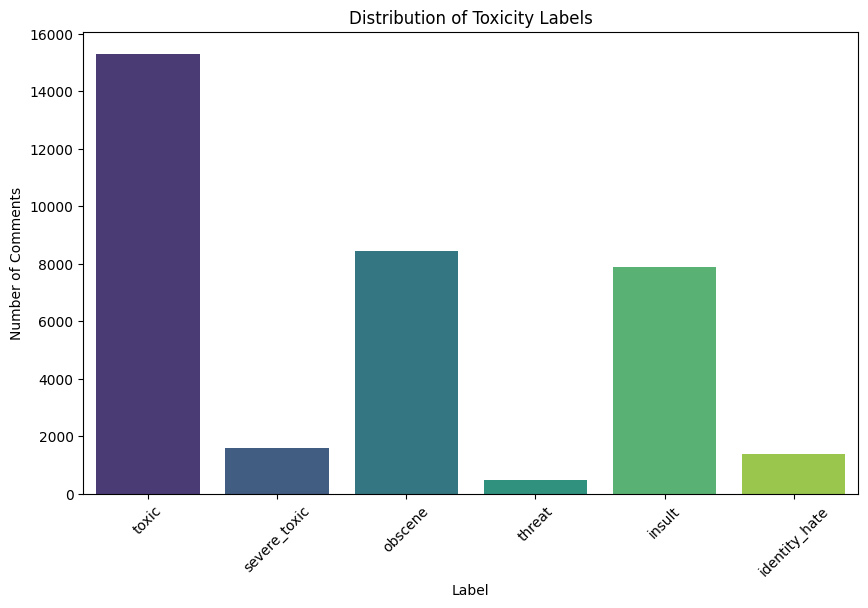

Label Counts:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [16]:
# @title 2.4: Visualize Label Distribution (Class Imbalance)
import matplotlib.pyplot as plt
import seaborn as sns

# Sum the occurrences of each label
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = df[label_cols].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Toxicity Labels")
plt.ylabel("Number of Comments")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.show()

print("Label Counts:\n", label_counts)

**Observation:** The dataset is highly imbalanced. The toxic label is the most common, while labels like threat and severe_toxic are very rare. We will need to address this during training.

#3. Data Preprocessing
We will perform minimal text cleaning. Modern transformer models can often handle raw text quite well, but removing noise like IP addresses and usernames can be beneficial.

In [17]:
# @title 3.1: Text Cleaning Function
import re

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    # Remove any characters that are not letters, numbers, or standard punctuation
    text = re.sub(r'[^a-z\s]', '', text, re.I|re.A)
    text = text.strip() # remove whitespace
    return text

# Apply the cleaning function
df['cleaned_comment_text'] = df['comment_text'].apply(clean_text)

# Show an example
print("Original:\n", df['comment_text'][0])
print("\nCleaned:\n", df['cleaned_comment_text'][0])

Original:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Cleaned:
 explanation
why the edits made under my username hardcore metallica fan were reverted they were not  vandalisms just closure on some gas after i voted at new york dolls fac and please do not  remove the template from the talk page since i am  retired now


#4. Preparing Data for Hugging Face
We need to convert our data into a format that the Hugging Face Trainer API understands. This involves creating a Dataset object and tokenizing the text.

In [18]:
# @title 4.1: Create Hugging Face Dataset
from datasets import Dataset

# Create labels column as a list of floats
df['labels'] = df[label_cols].values.tolist()
df_hf = df[['cleaned_comment_text', 'labels']]

# Convert to Hugging Face Dataset object
dataset = Dataset.from_pandas(df_hf)

# Split the dataset into training and testing sets
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset['train']
test_dataset = dataset['test']

print(train_dataset)
print(test_dataset)

Dataset({
    features: ['cleaned_comment_text', 'labels'],
    num_rows: 143613
})
Dataset({
    features: ['cleaned_comment_text', 'labels'],
    num_rows: 15958
})


In [19]:
# @title 4.2: Tokenize the Text
from transformers import AutoTokenizer

MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(
        examples["cleaned_comment_text"],
        padding="max_length",
        truncation=True,
        max_length=128 # A reasonable max length for comments
    )

# Apply tokenization to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove the original text column as it's no longer needed
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["cleaned_comment_text"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["cleaned_comment_text"])

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

Map:   0%|          | 0/143613 [00:00<?, ? examples/s]

Map:   0%|          | 0/15958 [00:00<?, ? examples/s]

#5. Modeling & Training
This is the core of the project. We will load a pre-trained DistilBERT model, configure it for multi-label classification, and define a custom `Trainer` to handle the class imbalance.

In [20]:
# @title 5.1: Load Pre-trained Model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(label_cols),
    problem_type="multi_label_classification" # CRITICAL for multi-label task
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To handle the severe class imbalance, we'll calculate class weights and use a custom `Trainer` with a weighted loss function. This makes the model pay more attention to the rare classes.

In [21]:
# @title 5.2: Configure Custom Trainer for Class Imbalance (Corrected)
import torch
from transformers import Trainer, TrainingArguments

# Calculate positive weights for the loss function
# pos_weight = (number of negative samples) / (number of positive samples)
pos_weights = (len(df) - label_counts) / label_counts
# Ensure the tensor is on the same device as the model (e.g., GPU)
pos_weights_tensor = torch.tensor(pos_weights.values).cuda()

class MultilabelTrainer(Trainer):
    """Custom trainer to handle weighted loss for multi-label classification."""
    # THE FIX: Add **kwargs to the function signature
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

Now, we define the metrics for evaluation. It would be nice to have an F1-score greater than 0.90 on the "toxic" label

In [22]:
# @title 5.3: Define Evaluation Metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
import numpy as np

def multi_label_metrics(predictions, labels, threshold=0.5):
    # Apply sigmoid on predictions and then a threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    # Calculate metrics
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)

    # The metrics dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    return metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return multi_label_metrics(predictions, labels)

Finally, we configure the training arguments and start the training process.

In [23]:
# @title 5.4: Configure and Start Training
training_args = TrainingArguments(
    output_dir=f"{DRIVE_PROJECT_PATH}/checkpoints",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # Batch size
    per_device_eval_batch_size=32,
    num_train_epochs=3, # A few epochs are usually enough for fine-tuning
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

trainer = MultilabelTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training!
trainer.train()

<ipython-input-23-274739211>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultilabelTrainer.__init__`. Use `processing_class` instead.
  trainer = MultilabelTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: georgejupiter303 (georgejupiter303-kumoh-national-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.339000,0.481543,0.726566,0.941787,0.895162
2,0.271700,0.401713,0.715833,0.948633,0.886640
3,0.208800,0.500873,0.743714,0.941609,0.903121


TrainOutput(global_step=13464, training_loss=0.32484319644957443, metrics={'train_runtime': 4656.3055, 'train_samples_per_second': 92.528, 'train_steps_per_second': 2.892, 'total_flos': 1.4269048192654848e+16, 'train_loss': 0.32484319644957443, 'epoch': 3.0})

#6. Evaluation
With the training complete, let's evaluate our model's performance on the held-out test set. We'll generate a detailed classification report to inspect the performance for each label.

In [24]:
# @title 6.1: Final Evaluation on the Test Set
print("Evaluating on the test set...")
eval_results = trainer.evaluate()
print(f"Final Evaluation Metrics: {eval_results}")

# Generate predictions to create a classification report
print("\nGenerating classification report...")
test_predictions = trainer.predict(tokenized_test_dataset)
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(test_predictions.predictions))
preds = np.zeros(probs.shape)
preds[np.where(probs >= 0.5)] = 1

report = classification_report(test_predictions.label_ids, preds, target_names=label_cols, zero_division=0)
print(report)

Evaluating on the test set...


Final Evaluation Metrics: {'eval_loss': 0.5008727312088013, 'eval_f1': 0.7437137330754352, 'eval_roc_auc': 0.9416094683762092, 'eval_accuracy': 0.9031206918160171, 'eval_runtime': 54.8641, 'eval_samples_per_second': 290.864, 'eval_steps_per_second': 9.095, 'epoch': 3.0}

Generating classification report...
               precision    recall  f1-score   support

        toxic       0.72      0.90      0.80      1495
 severe_toxic       0.34      0.84      0.48       157
      obscene       0.70      0.94      0.80       804
       threat       0.39      0.77      0.52        53
       insult       0.61      0.92      0.73       767
identity_hate       0.40      0.78      0.53       132

    micro avg       0.63      0.90      0.74      3408
    macro avg       0.53      0.86      0.64      3408
 weighted avg       0.65      0.90      0.75      3408
  samples avg       0.07      0.08      0.07      3408



**Success Metric Check:** Look at the f1-score for the toxic label in the report above.

In [25]:
# @title 6.2: Find Optimal Thresholds and Re-Evaluate

from sklearn.metrics import f1_score
import numpy as np

# We already have the predictions from the previous cell
# test_predictions.predictions are the raw logits
# test_predictions.label_ids are the true labels
logits = test_predictions.predictions
y_true = test_predictions.label_ids

# Apply sigmoid to convert logits to probabilities
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))

# Find the best threshold for each label
best_thresholds = []
best_f1_scores = []

print("Searching for optimal threshold for each label...")
for i, label in enumerate(label_cols):
    best_f1 = 0
    best_thresh = 0.5
    # Test thresholds from 0.1 to 0.9
    for threshold in np.arange(0.1, 1.0, 0.05):
        y_pred = (probs[:, i] > threshold).int()
        f1 = f1_score(y_true[:, i], y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = threshold
    best_thresholds.append(best_thresh)
    best_f1_scores.append(best_f1)
    print(f"- Label: {label}, Best Threshold: {best_thresh:.2f}, Best F1: {best_f1:.4f}")

# Now, let's apply these new thresholds to get a final classification report
print("\nGenerating new classification report with optimal thresholds...")
y_pred_optimal = np.zeros(probs.shape)
for i in range(len(label_cols)):
    y_pred_optimal[:, i] = (probs[:, i] > best_thresholds[i]).int()

report = classification_report(y_true, y_pred_optimal, target_names=label_cols, zero_division=0)
print(report)

Searching for optimal threshold for each label...
- Label: toxic, Best Threshold: 0.90, Best F1: 0.8266
- Label: severe_toxic, Best Threshold: 0.95, Best F1: 0.5428
- Label: obscene, Best Threshold: 0.90, Best F1: 0.8467
- Label: threat, Best Threshold: 0.95, Best F1: 0.5920
- Label: insult, Best Threshold: 0.90, Best F1: 0.7700
- Label: identity_hate, Best Threshold: 0.90, Best F1: 0.5443

Generating new classification report with optimal thresholds...
               precision    recall  f1-score   support

        toxic       0.82      0.83      0.83      1495
 severe_toxic       0.44      0.71      0.54       157
      obscene       0.82      0.88      0.85       804
       threat       0.51      0.70      0.59        53
       insult       0.71      0.84      0.77       767
identity_hate       0.48      0.63      0.54       132

    micro avg       0.75      0.83      0.79      3408
    macro avg       0.63      0.76      0.69      3408
 weighted avg       0.76      0.83      0.79 

#7. Save the Model

The final step is to save the trained model and tokenizer. We'll save it in the modern `.safetensors` format

In [26]:
# @title 7.1: Save Model for Future Use
MODEL_SAVE_PATH = f"{DRIVE_PROJECT_PATH}/distilbert-toxicity-classifier"

# Save the model and tokenizer
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

# Also save in the requested .safetensors format
trainer.model.save_pretrained(MODEL_SAVE_PATH, safe_serialization=True)

print(f"Model saved to: {MODEL_SAVE_PATH}")
!ls -l {MODEL_SAVE_PATH} # Verify the files are there

Model saved to: /content/drive/MyDrive/ToxicityClassifier/distilbert-toxicity-classifier
total 262498
-rw------- 1 root root       836 Jun 14 09:01 config.json
-rw------- 1 root root 267844872 Jun 14 09:01 model.safetensors
-rw------- 1 root root       125 Jun 14 09:01 special_tokens_map.json
-rw------- 1 root root      1227 Jun 14 09:01 tokenizer_config.json
-rw------- 1 root root    711661 Jun 14 09:01 tokenizer.json
-rw------- 1 root root      5368 Jun 14 09:01 training_args.bin
-rw------- 1 root root    231508 Jun 14 09:01 vocab.txt


#8. Inference: Test with Your Own Text
Let's do a quick test to see how our fine-tuned model performs on new comments.

In [27]:
# @title 8.1: Create an Inference Pipeline
from transformers import pipeline

# Load the saved model
pipe = pipeline("text-classification", model=MODEL_SAVE_PATH, tokenizer=MODEL_SAVE_PATH, return_all_scores=True)

# Test comments
test_comments = [
    "You are an amazing and talented person! Keep up the great work!",
    "I'm going to find you and hurt you.",
    "Go back to your country you idiot, you don't belong here.",
    "That is just a stupid idea, what were you thinking?"
]

# Get predictions
results = pipe(test_comments)

# Display results in a readable format
for i, comment in enumerate(test_comments):
    print(f"\nCOMMENT: \"{comment}\"")
    # Sort labels by score in descending order
    sorted_labels = sorted(results[i], key=lambda x: x['score'], reverse=True)
    for label_info in sorted_labels:
        # Only show labels with a score > 0.1 for clarity
        if label_info['score'] > 0.1:
            print(f"  - {label_info['label']}: {label_info['score']:.4f}")

Device set to use cuda:0



COMMENT: "You are an amazing and talented person! Keep up the great work!"

COMMENT: "I'm going to find you and hurt you."
  - LABEL_3: 0.9856
  - LABEL_0: 0.9845
  - LABEL_4: 0.3076
  - LABEL_2: 0.1495

COMMENT: "Go back to your country you idiot, you don't belong here."
  - LABEL_4: 0.9962
  - LABEL_0: 0.9962
  - LABEL_2: 0.9652

COMMENT: "That is just a stupid idea, what were you thinking?"
  - LABEL_0: 0.8687


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
